In [1]:
from ase.io import read
import ase

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.analysis.graphs import MoleculeGraph
from pymatgen.analysis.local_env import OpenBabelNN, CovalentBondNN

import networkx as nx
import os

In [2]:
from monty.serialization import loadfn
from glob import glob
import time
from tqdm import tqdm
import collections
import numpy as np
import matplotlib.pyplot as plt


In [3]:
from radqm9_pipeline.modules import (bucket_mol_id_all_pts,
                                    train_val_test_split,
                                    build_manager,
                                    merge_data,
                                    force_magnitude_filter,
                                    flatten,
                                    tagger,
                                    build_atoms_iterator)
from radqm9_pipeline.elements import read_elements

In [4]:
# from radqm9_pipeline.validators import composition_validator

In [4]:
# # atoms = read("/pscratch/sd/m/mavaylon/sam_ldrd/C4H8_disconnected.xyz")
# mol = AseAtomsAdaptor.get_molecule(atoms)
# graph = MoleculeGraph.with_local_env_strategy(mol, OpenBabelNN())

In [5]:
# atoms.symbols

# Set elements


In [11]:
elements_dict = read_elements('/pscratch/sd/m/mavaylon/sam_ldrd/radqm9_pipeline/src/radqm9_pipeline/modules/elements.pkl')

# Set Data Directory

In [7]:
base_dir = "/pscratch/sd/m/mavaylon/sam_ldrd/radqm9/updated_rad_qm9_raw/data/20230907_radQM9_trajectories"

# Load and Merge Data

In [4]:
# merged_data=merge_data(base_dir)

In [214]:
len(merged_data)

616958

In [216]:
# merged_data[0]

In [217]:
# import h5py
# with h5py.File('/pscratch/sd/m/mavaylon/sam_ldrd/merged_raw_data.h5', 'w') as file:
#     g1 =file.create_group('raw')
#     raw=[]
#     for item in tqdm(merged_data):
#         raw.append(str(item))
#     g1.create_dataset('raw_data',data=raw)

100%|██████████| 616958/616958 [16:59<00:00, 605.20it/s]  


In [5]:
# import h5py
# import ast
# merged_file = h5py.File('/pscratch/sd/m/mavaylon/sam_ldrd/merged_raw_data.h5', 'r')


In [9]:
# merged_file['raw']['raw_data'][0]

In [5]:
# merged_data=[]
# for point in tqdm(merged_file['raw']['raw_data']):
#     point = ast.literal_eval(point.decode('utf-8'))
#     merged_data.append(point)


# Filter Data

In [7]:
def bucket_mol_id_all_pts(data: list):
    """
    Method requires a list of events such that each item in the list is a single event.
    
    Steps:
    - Bucket the events in a dictionary such that the keys are the mol_ids and the values are all events with that mol_id. Create
      a new field for each event called "charge_spin" for easy down_stream checks.
    - For each mol_id, check the list of events for duplicate "charge_spin". 
      If there are duplicates, for each duplicate pair:
                1. Get all events that have the duplicate charge_spin
                2. Remove these events from the values of the mol_id in the bucket. This is to process them and re-add them later or move to
                   bad data.
                3. Search for the order in which these duplicate events for the specific charge_spin should be attached. If there is no match,
                   this is considered bad data and will be moved out of the bucket.
                4. If an order can be established, create a new "merged" event. 
                5. Append the event to the values of the mol_id of the bucket.
                6. Repeat for every duplicate pair.
    """
    bucket = {}
    
    # Step 1    
    for event in tqdm(data):
        event['charge_spin'] = str(event['charge'])+','+str(event['spin'])
        try:
            bucket[event['mol_id']].append(event) 
        except KeyError:
            bucket[event['mol_id']] = [event]

    # Step 2
    bad_ids = []
    for mol_id in tqdm(bucket):
        pairs = [event['charge_spin'] for event in bucket[mol_id]]
        # Get a list of all charge_spins that have duplicates.
        duplicate_pairs = [item for item, count in collections.Counter(pairs).items() if count > 1] 
        non_dup_pairs = []
        if len(duplicate_pairs)!=0:
            non_dup_pairs = list(set(pairs))
            for i in duplicate_pairs:
                non_dup_pairs.remove(i)
        
        if len(duplicate_pairs)==0:
            for pair in bucket[mol_id]:
                # add weight tag
                species = pair['species']
                species_num = []
                species_sorted = ''.join(sorted(set(species)))
                for element in species:
                    species_num.append(elements_dict[element])
                    
                pair['weight_tag'] = round(sum(species_num))
        else:
            if len(non_dup_pairs)!=0:
                for pair in non_dup_pairs:
                    case_events = [event for event in bucket[mol_id] if event['charge_spin']==pair]
                    for event in case_events:
                        # add weight tag
                        species = event['species']
                        species_num = []
                        species_sorted = ''.join(sorted(set(species)))
                        for element in species:
                            species_num.append(elements_dict[element])

                        event['weight_tag'] = round(sum(species_num)) 

            bad_data = []
            for dup in duplicate_pairs:
                # Order events
                case_events = [event for event in bucket[mol_id] if event['charge_spin']==dup]
                for event in case_events:
                    bucket[mol_id].remove(event) 
                
                ordered = [case_events[0]]
                del case_events[0]
                
                counter = 0
                threshold = 30
                while len(case_events)!=0:
                    if len(bad_data)==0:
                        for event in case_events:
                            beg = event['geometries'][0]
                            end = event['geometries'][len(event['geometries'])-1]

                            ordered_beg = ordered[0]['geometries'][0]
                            ordered_end = ordered[len(ordered)-1]['geometries'][len(ordered[len(ordered)-1]['geometries'])-1]

                            if beg==ordered_end:
                                ordered.append(event)
                                case_events.remove(event)
                            elif end==ordered_beg:
                                ordered.insert(0, event)
                                case_events.remove(event)
                            else:
                                counter+=1
                                if counter>threshold:
                                    bad_data.append(mol_id)
                                else:
                                    continue
                    else:
                        break
                    
                if len(bad_data)==0:
                    pass
                else:
                    bad_ids += bad_data
                    continue

                # Merge the ordered events: forces, geometries
                merged_event = {}
                merged_event['task_id'] = ordered[0]['task_id']
                merged_event['mol_id'] = mol_id
                merged_event['name'] = ordered[0]['name']
                merged_event['charge'] = ordered[0]['charge']
                merged_event['spin'] = ordered[0]['spin']
                merged_event['charge_spin'] = ordered[0]['charge_spin']
                merged_event['species'] = ordered[0]['species']
                
                geometries = []
                energies = []
                grads = []
                mulliken = []
                resp = []
                for event in ordered:
                    geometries += event['geometries']
                    energies += event['energies']
                    grads += event['gradients']
                    mulliken += event['mulliken']
                    resp += event['resp']
               
                merged_event['geometries'] = geometries
                merged_event['energies'] = energies
                merged_event['gradients'] = grads
                merged_event['mulliken'] = mulliken
                merged_event['resp'] = resp
                
                species = merged_event['species']
                species_num = []
                species_sorted = ''.join(sorted(set(species)))
                for element in species:
                    species_num.append(elements_dict[element])
                merged_event['weight_tag'] = round(sum(species_num))
                
                bucket[mol_id].append(merged_event)

    if len(bad_ids)!=0:
        ids = list(set(bad_ids))
        for _id in ids:
            bucket.pop(_id)
        
        return ids, bucket
    else:
        for mol_id in bucket:
            if len(bucket[mol_id])>4:
                print(mol_id)
        return bucket


In [218]:
bad_ids, all_pts_bucket = bucket_mol_id_all_pts(merged_data)

100%|██████████| 133882/133882 [00:03<00:00, 38190.80it/s]


In [219]:
len(all_pts_bucket.keys())

130170

In [ ]:
all_pts_bucket

In [220]:
def average_force_trajectory(pair):
    """
    This method will take a specfic spin charge pair. At each point in the optimization trajectory, the 
    """
    forces = {}
    for i in range(len(pair['gradients'])):
        temp = []
        for atom in pair['gradients'][i]:
            res = np.sqrt(sum([j**2 for j in atom]))
            temp.append(res)
        forces[i] = np.mean(temp)
    del forces[0]
    return forces

In [221]:
def sparse_trajectory(bucket: dict):
    """
    This takes the cleaned data and will sparsifiy the optimization trajectories. How this is done will depend on the
    charge_spin pair:
    - Neutral Singlet (0,1): First and Last
    - Other: First, Last, and structure with the highest molecular force other than the First.
    
    Note: Molecular Force is just the average of the force magnitudes of each atom in the molecule:
    """
    
    for mol_id in tqdm(bucket):
        for pair in bucket[mol_id]:
            if pair['charge_spin'] == '0,1':
                geometries = [pair['geometries'][0], pair['geometries'][-1]]
                energies = [pair['energies'][0], pair['energies'][-1]]
                grads = [pair['gradients'][0], pair['gradients'][-1]]
                mulliken = [pair['mulliken'][0], pair['mulliken'][-1]]
                resp = [pair['resp'][0], pair['resp'][-1]]
                
                pair['geometries'] = geometries
                pair['energies'] = energies
                pair['gradients'] = grads
                pair['mulliken'] = mulliken
                pair['resp'] = resp
            else:
                force_dict = average_force_trajectory(pair)
                max_index = max(force_dict, key=force_dict.get)
                
                geometries = [pair['geometries'][0], pair['geometries'][max_index], pair['geometries'][-1]]
                energies = [pair['energies'][0], pair['energies'][max_index], pair['energies'][-1]]
                grads = [pair['gradients'][0], pair['gradients'][max_index], pair['gradients'][-1]]
                mulliken = [pair['mulliken'][0], pair['mulliken'][max_index], pair['mulliken'][-1]]
                resp = [pair['resp'][0], pair['resp'][max_index], pair['resp'][-1]]
                
                pair['geometries'] = geometries
                pair['energies'] = energies
                pair['gradients'] = grads
                pair['mulliken'] = mulliken
                pair['resp'] = resp

In [222]:
sparsed_bucket = sparse_trajectory(all_pts_bucket)

100%|██████████| 130170/130170 [06:46<00:00, 320.42it/s]


In [223]:
# how much data after sparse?
total=0
for mol_id in tqdm(all_pts_bucket):
    for pair in all_pts_bucket[mol_id]:
        total+=len(pair['geometries'])

100%|██████████| 130170/130170 [00:00<00:00, 314683.04it/s]


In [224]:
total

1400131

In [225]:
force_filtered, filtered_data = force_magnitude_filter(cutoff=10.0, data=all_pts_bucket)

100%|██████████| 130170/130170 [00:32<00:00, 4029.88it/s]


In [226]:
# how much data after force filter?
total=0
for mol_id in tqdm(filtered_data):
    for pair in filtered_data[mol_id]:
        total+=len(pair['geometries'])

100%|██████████| 130170/130170 [00:00<00:00, 311815.04it/s]


In [227]:
total

1399906

In [ ]:
def prepare_graph_filter(data: dict):
    """
    Go through the data and retrieve the data needed for graph separation check.
    1. Ignore charge_spin pair = 0,1
    2. Ignore all starting points in the configurations.
    """
    data_to_be_parsed = []
    for mol_id in tqdm(data):
        for pair in data[mol_id]:
            if pair['charge_spin'] != '0,1':
                data_to_be_parsed.append(pair)
    
    # Ignore the first is in the filter_broken_graphs
    return data_to_be_parsed

In [ ]:
dd = prepare_graph_filter(filtered_data)

In [ ]:
def filter_broken_graphs(data: list):
    broken = []
    good = []
    
    for item in tqdm(data):
        for traj_point in item['geometries'][1:]:
                atoms = ase.atoms.Atoms(symbols=item['species'],
                                        positions=traj_point)
                mol = AseAtomsAdaptor.get_molecule(atoms)
                graph = MoleculeGraph.with_local_env_strategy(mol, OpenBabelNN())

                connected = nx.is_connected(graph.graph.to_undirected())
                if not connected:
                    broken.append(item)
                else:
                    good.append(item)

    return good, broken

In [ ]:
good,broken = filter_broken_graphs(dd)

In [ ]:
# import h5py
# with h5py.File('/pscratch/sd/m/mavaylon/sam_ldrd/broken.h5', 'w') as file:
#     g1 =file.create_group('broken')
#     bbd=[]
#     for item in broken:
#         bbd.append(str(item))
#     g1.create_dataset('broken_data',data=bbd)

In [228]:
import ast
import h5py
file = h5py.File('/pscratch/sd/m/mavaylon/sam_ldrd/broken.h5', 'r')

broken_dict={}
for point in tqdm(file['broken']['broken_data']):
    try:
        point = ast.literal_eval(point.decode('utf-8'))
        broken_dict[str(point['task_id']) +'_'+str(point['mol_id'])+'_'+point['charge_spin']] = point
    except KeyError:
        pass


100%|██████████| 25888/25888 [00:39<00:00, 661.53it/s]


In [236]:
# filtered_data[3832]

In [230]:
def removed_broken_graph_data(data: dict,
                              broken: list):
    """
    
    """
    data_to_be_parsed = {}
    for mol_id in tqdm(data):
        for pair in data[mol_id]:
            # data_to_be_parsed.append(pair)
            data_to_be_parsed[str(pair['task_id']) +'_'+str(pair['mol_id'])+'_'+pair['charge_spin']] = pair
    print(len(data_to_be_parsed))
    
    print(len(broken))
    for item in tqdm(broken):
        data_to_be_parsed.pop(item)
    
    print(len(data_to_be_parsed))
    
    return data_to_be_parsed

In [231]:
cleaned_data = removed_broken_graph_data(filtered_data, broken_dict)

100%|██████████| 130170/130170 [00:00<00:00, 209379.18it/s]


509920
17353


100%|██████████| 17353/17353 [00:00<00:00, 1566589.70it/s]

492567


In [234]:
len(cleaned_data.keys())

492567

In [16]:
file.close()

In [20]:
import ast
import h5py
with h5py.File('/pscratch/sd/m/mavaylon/sam_ldrd/cleaned_data.h5', 'w') as file:
    g1 =file.create_group('clean')
    cd=[]
    for item in tqdm(cleaned_data):
        cd.append(str(cleaned_data[item]))
    g1.create_dataset('cleaned_data',data=cd)

100%|██████████| 492567/492567 [01:25<00:00, 5763.51it/s]


In [6]:
import ast
import h5py
file = h5py.File('/pscratch/sd/m/mavaylon/sam_ldrd/cleaned_data.h5', 'r')

In [7]:
cleaned_read_data={}
for point in tqdm(file['clean']['cleaned_data']):
    point = ast.literal_eval(point.decode('utf-8'))
    cleaned_read_data[str(point['task_id']) +'_'+str(point['mol_id'])+'_'+point['charge_spin']] = point


100%|██████████| 492567/492567 [11:04<00:00, 741.53it/s] 


In [7]:
# cleaned_read_data

# Split the Data

In [8]:
def __mol_id_weight_bins(data: dict):
    """
    This method takes in the output from removing the broken graphs.
    
    1. Bin the data by mol_ids in a dict.

    For each mol_id, calculate the molecule weight based off the atoms. Combine that with that type of atoms used.
    This weight+type serves as a key for a dict. The values are then the mol_ids that match the key.
    
    The intent is create a dict such that we can sample from evenly based on weight. We also want to ensure even
    representation of atom type across train/val/test, hence why we include the atoms used in the key.
    """
    bucket={}
    for item in tqdm(data):
        try:
            bucket[data[item]['mol_id']].append(data[item])
        except KeyError:
            bucket[data[item]['mol_id']] = [data[item]]
    
    
    weight_dist = {}
    weight_dict = {}
    for mol_id in tqdm(bucket):
        species = bucket[mol_id][0]['species']
        species_num = []
        species_sorted = ''.join(sorted(set(species)))
        for element in species:
            species_num.append(elements_dict[element])

        try:
            weight_dist[round(sum(species_num))]+=1
        except KeyError:
            weight_dist[round(sum(species_num))]=1
            
        try:
            weight_dict[str(sum(species_num))+'_'+species_sorted].append(mol_id)

        except KeyError:
            weight_dict[str(sum(species_num))+'_'+species_sorted] = [mol_id]
    
    return weight_dict, weight_dist, bucket


In [10]:
w,ww,www=__mol_id_weight_bins(cleaned_read_data)

100%|██████████| 130144/130144 [00:00<00:00, 316497.84it/s]


In [107]:
fff=[len(w[x])for x in w] 
len([x for x in fff if x<20])/len(fff)

0.6386925795053003

In [12]:
def train_val_test_split(bucket: dict,
                         train_size: float,
                         val_size: float):
    """
    This method takes in the output from mol_id_weight_bins.
    This method will sample from each key-value pair from the input dict based on the train_size, val_size.
    The method requires a validation set, but the user can combine it with test if they so choose.
    """
    
    weight_dict, weight_dist, bucket = __mol_id_weight_bins(bucket)
    
    train_marker = train_size
    val_marker = train_size + val_size
    
    split={}

    import random
    random.seed(10)
    for strata in tqdm(weight_dict):
        random.shuffle(weight_dict[strata])
        train_index = round(len(weight_dict[strata])*train_marker)
        val_index = round(len(weight_dict[strata])*val_marker)
        # print(len(weight_dict[strata]))
        # print(train_index)
        # print(val_index)
        # break
              
        
        try:
            train_split = (weight_dict[strata][:train_index])
            val_split = (weight_dict[strata][train_index:val_index+1])
            test_split = (weight_dict[strata][val_index+1:])
            
            if len(test_split)> len(val_split):
                print('bleh')
                return [weight_dict[strata], train_split, val_split, test_split, train_index, val_index+1]
            
            split['train']+=train_split
            split['val']+=val_split
            split['test']+=test_split
            
            
        except KeyError:
            split['train'] = weight_dict[strata][:train_index]
            split['val'] = weight_dict[strata][train_index:val_index+1]
            split['test'] = weight_dict[strata][val_index+1:]
    train_data = [bucket[i] for i in split['train']]
    val_data = [bucket[i] for i in split['val']]
    test_data = [bucket[i] for i in split['test']]
                 
    split['train']=train_data
    split['val']=val_data
    split['test']=test_data
    
    return split, weight_dist

In [13]:
data_dict_spit, weight_dist = train_val_test_split(cleaned_read_data, train_size=.65, val_size=.25)

100%|██████████| 1132/1132 [00:00<00:00, 30874.16it/s]


In [201]:
# len(data_dict_spit['val'])

In [43]:
def composition_validator(train, val, test):
    """
    Each are lists. Validate atomic weight distribution and element distribution.
    
    - check that for each mol_id there are four instances enclosed in a split
    
    - Weight count
    - Number of element occurances in each split
    """
    elements_dict = read_elements('/pscratch/sd/m/mavaylon/sam_ldrd/radqm9_pipeline/src/radqm9_pipeline/modules/elements.pkl')
    # weight count
    sets = [train, val, test]
    
    total = [item for sublist in sets for item in sublist]
    total_dict = {}
    total_element_dict = {}
    for mol_id in tqdm(total):
        # check for four charge_spin pairs
        if len(mol_id)!=4:
            #add
            pass

        # weight distribution
        species = mol_id[0]['species']
        species_num = []
        species_sorted = ''.join(sorted(set(species)))
        for element in species:
            species_num.append(elements_dict[element])
        try:
            total_dict[str(sum(species_num))]+= 1
        except KeyError:
            total_dict[str(sum(species_num))]=1
        
        for element in list(set(species)):
            try:
                total_element_dict[element] += 1
            except KeyError:
                total_element_dict[element] =1 
    # return total_dict
    
    set_weight = []
    element_list = []
    for split in sets:
        weight_dict = {}
        ratio_dict = {}
        split_element_dict = {}
        ratio_element_dict = {}
        for mol_id in tqdm(split):
            # check for four charge_spin pairs
            if len(mol_id)!=4:
                #add
                pass
            
            # weight distribution
            species = mol_id[0]['species']
            species_num = []
            species_sorted = ''.join(sorted(set(species)))
            for element in species:
                species_num.append(elements_dict[element])
            try:
                weight_dict[str(sum(species_num))]+= 1
            except KeyError:
                weight_dict[str(sum(species_num))]=1
            
            for element in list(set(species)):
                try:
                    split_element_dict[element] += 1
                except KeyError:
                    split_element_dict[element] =1 
        
        for key in weight_dict:
            try:
                ratio = weight_dict[key]/total_dict[key]
                ratio_dict[key] = ratio
            except ZeroDivisionError:
                return key
            
        set_weight.append(ratio_dict)
        
        for element in split_element_dict:
            element_ratio = split_element_dict[element]/total_element_dict[element]
            ratio_element_dict[element] = element_ratio
        
        element_list.append(ratio_element_dict)
    
    return set_weight, total_dict , total_element_dict, element_list

In [44]:
r,t,q, w=composition_validator(data_dict_spit['train'], data_dict_spit['val'], data_dict_spit['test'])

100%|██████████| 12271/12271 [00:00<00:00, 298347.96it/s]


# Use the BuildManager to Tag and Prepare the Data

In [82]:
# prepped_data=build_manager(data_dict_spit, weight_dist, train=True)
# data_dict_spit['val']

In [16]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [17]:
def tagger(train_data, dist):
    
    # Flatten train_data into a pool of data points
    flat = [x for y in train_data for x in y] 
    
    # Find all the weights that appear less than 20 occurances
    # cutoff_bin = [x for x in dist if .05*dist[x]<1]
    
    bins = {}
    chunked_training = {}
    
    for point in flat:
        try:
            bins[point['weight_tag']].append(point['mol_id'])
        except KeyError:
            bins[point['weight_tag']] = [point['mol_id']]
        
    
    mol_id_tag = {}
    chunks = []
    for weight_group in tqdm(bins):
        tag_groups = list(split(list(set(bins[weight_group])),20))
        chunk = 0
        for group in tag_groups:
            for mol_id in group:
                chunks.append(chunk)
                mol_id_tag[mol_id] = chunk
            chunk += 5
    print(set(chunks))
    
    for point in tqdm(flat):
        if point['mol_id'] in mol_id_tag:
            point['chunk'] = mol_id_tag[point['mol_id']] 
            try:
                chunked_training[mol_id_tag[point['mol_id']]].append(point)
            except KeyError:
                chunked_training[mol_id_tag[point['mol_id']]] = [point]
    return flat, chunked_training


In [18]:
training, disjoint_chunked_training = tagger(data_dict_spit['train'], weight_dist)
val = flatten(data_dict_spit['val'])
test = flatten(data_dict_spit['test'])

100%|██████████| 104/104 [00:00<00:00, 2402.28it/s]


{0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95}


100%|██████████| 320353/320353 [00:00<00:00, 1299613.95it/s]


In [56]:
# 5%, 10%, 25%, 50%, 75%, 100%

['N', 'C', 'N', 'N', 'N', 'C', 'C', 'H', 'H', 'H', 'H']

In [29]:
def temp(data: list):
    mol_id_bucket = {}
    for point in tqdm(data):
        try:
            mol_id_bucket[point['mol_id']].append(point)
        except KeyError:
            mol_id_bucket[point['mol_id']] = [point]
    return mol_id_bucket

In [30]:
yy=temp(training)
#15665, 13257, 12519, 12226, 19210, 4110,

100%|██████████| 320353/320353 [00:00<00:00, 1391533.58it/s]


In [32]:
type(list(set([x['charge'] for x in yy[4110]]))[0])

int

In [213]:
set([x['charge_spin'] for x in yy[3844]])

{'-1,2', '0,1', '0,3', '1,2'}

# Optional Charge Filtering

In [35]:
def charge_filter(charges: list, data):
    """
    Takes both a list of charges to filter by and a dataset that is a list of data points.
    """
    filtered_data = []
    for point in tqdm(data):
        if point['charge'] in charges:
            filtered_data.append(point)
    
    return filtered_data

In [37]:
charge_filtered_training = charge_filter(charges=[-1, 1], data=training)

100%|██████████| 160414/160414 [00:00<00:00, 1022709.26it/s]


In [40]:
len(charge_filtered_training)

160414

In [42]:
len(training)

320353

In [50]:
charge_filtered_val = charge_filter(charges=[-1, 1], data=val)

100%|██████████| 125712/125712 [00:00<00:00, 1058890.14it/s]


In [51]:
charge_filtered_test = charge_filter(charges=[-1, 1], data=test)

100%|██████████| 46502/46502 [00:00<00:00, 1030090.55it/s]


# Chunk

In [19]:
def chunk_train_multiple(data: list, percentage: list):
    """
    Percentage: list of percentages e.g., [.05, .1, .25, .5, .75]
    """
    mol_id_bucket = {}
    for point in tqdm(data):
        try:
            mol_id_bucket[point['mol_id']].append(point)
        except KeyError:
            mol_id_bucket[point['mol_id']] = [point]
    
    
    elements_dict = read_elements('/pscratch/sd/m/mavaylon/sam_ldrd/radqm9_pipeline/src/radqm9_pipeline/modules/elements.pkl')
    
    ##################
    # Create a weight dictionary such that the keys are the unique weights using atomic mass of the molecule
    # as a float and the values are list of mol_ids that correspond to said weight. 
    ##################
    weight_dict = {}
    for point in tqdm(data):
        species = point['species']
        species_num = 0
        for element in species:
            species_num+=elements_dict[element]
        try:
            weight_dict[str(species_num)].append(point['mol_id'])
            weight_dict[str(species_num)] = list(set(weight_dict[str(species_num)]))
        except KeyError:
            weight_dict[str(species_num)] = [point['mol_id']]
    
    ##################
    # Calculate total data points
    ##################
    total=0
    for pair in tqdm(data):
        total+=len(pair['geometries'])
    print(total)
    
    ##################
    # Calculate the size for the data chunk for each percentage
    ##################
    sizes = []
    for item in percentage:
        temp_size = round(total*item)
        sizes.append(temp_size)
    
    ##################
    # Get the chunked mol_ids for each size
    ##################
    chunks = []
    count = 0
    
    for size in tqdm(sizes):
        print("size:", size)
        chunked_mol_id_data = []
        # while count<size:
        for i in tqdm(range(total)):
            if count<size:
                for key in weight_dict:
                    if len(weight_dict[key])!=0:
                        _id = weight_dict[key][0]
                        for point in mol_id_bucket[_id]:
                            count += len(point['geometries'])
                        # print(count)

                        chunked_mol_id_data.append(_id)
                        weight_dict[key] = weight_dict[key][1:]

                    else:
                        pass
                weight_dict = {k: v for (k,v) in weight_dict.items() if len(v)!=0}

            else:
                break
        print('count:', count)
        # print(len(chunked_mol_id_data))
        chunks.append(chunked_mol_id_data)
        
        for item in chunks:
            print(len(item))
        
    chunked_data = []
    for chunk_set in tqdm(chunks):
        chunk = []
        for item in tqdm(chunk_set):
            chunk+=mol_id_bucket[item]
        chunked_data.append(chunk)
    
    return chunked_data, weight_dict
    # return chunks
    # return weight_dict

In [20]:
tt, w=chunk_train_multiple(training, [.01])

100%|██████████| 320353/320353 [00:00<00:00, 1879888.56it/s]


876616


  0%|          | 0/1 [00:00<?, ?it/s]

size: 8766



100%|██████████| 1/1 [00:00<00:00, 163.39it/s]


count: 11634
1132


100%|██████████| 1/1 [00:00<00:00, 423.24it/s]


In [21]:
# tt, w=chunk_train_multiple(training, [.05,.1,.25, .5, .75])

In [22]:
# tt, w=chunk_train_multiple(charge_filtered_training, [.05,.1,.25, .5, .75])

In [24]:
len(tt[0])

4255

In [66]:
chunked_data = {0: tt[0],
                1: tt[0] + tt[1],
                2: tt[0] + tt[1] +tt[2],
                3: tt[0] + tt[1] +tt[2] + tt[3],
                4: tt[0] + tt[1] +tt[2] + tt[3] + tt[4]}

In [67]:
c =0
for item in chunked_data[0]:
    c+=len(item['geometries'])
c/481242

0.053636216290348725

In [68]:
k=0
for item in chunked_data[1]:
    k+=len(item['geometries'])
k/481242

0.10112583689702893

In [69]:
k2=0
for item in chunked_data[2]:
    k2+=len(item['geometries'])
k2/481242

0.2503709152567731

In [70]:
k3=0+0
for item in chunked_data[3]:
    k3+=len(item['geometries'])
k3/481242

0.5006794918149289

In [25]:
k4=0
for item in chunked_data[4]:
    k4+=len(item['geometries'])
k4/876616

0.75020419431085

In [25]:
def chunk_validator(data, training):
    elements_dict = read_elements('/pscratch/sd/m/mavaylon/sam_ldrd/radqm9_pipeline/src/radqm9_pipeline/modules/elements.pkl')
    
    type_total_dict = {}
    for point in tqdm(training):
        species = point['species']
        species_num = 0
        for element in species:
            species_num+=elements_dict[element]
        try:
            type_total_dict[str(species_num)].append(point)
        except KeyError:
            type_total_dict[str(species_num)]= [point]
    
    
    element_list = []
    weight_dict = {}
    ratio_dict = {}
    split_element_dict = {}
    ratio_element_dict = {}
    for mol_id in tqdm(data):
        # check for four charge_spin pairs
        if len(mol_id)!=4:
            #add
            pass

        # weight distribution
        species = mol_id['species']
        species_num = []
        for element in species:
            species_num.append(elements_dict[element])
        try:
            weight_dict[str(sum(species_num))]+= 1
        except KeyError:
            weight_dict[str(sum(species_num))]=1

        for element in list(set(species)):
            try:
                split_element_dict[element] += 1
            except KeyError:
                split_element_dict[element] =1 

    output = {}
    for key in weight_dict:
        output[key] = [weight_dict[key], len(type_total_dict[key])]
    
    return output

In [176]:
vv=chunk_validator(chunked_data[2], training)

100%|██████████| 80566/80566 [00:00<00:00, 376404.53it/s]


In [26]:
vv=chunk_validator(tt[0], training)

100%|██████████| 4255/4255 [00:00<00:00, 167764.27it/s]


In [179]:
data = {'train':training,
        'val': val,
        'test': test}

In [57]:

data_charged_filtered = {'train':charge_filtered_training,
        'val': charge_filtered_val,
        'test': charge_filtered_test}

In [52]:
def build_atoms(data: dict,
                energy: str = None,
                forces: str = None,
                charge:str = None,
                spin:str = None,
                train = False) -> ase.Atoms:
    """ 
    Populate Atoms class with atoms in molecule.
        atoms.info : global variables
        atoms.array : variables for individual atoms
        
    Both "energy" and "forces" are the dict strings in data.
    """
    atom_list = []
    try:
        for i in range(len(data['geometries'])):
            atoms = ase.atoms.Atoms(
                symbols=data['species'],
                positions=data['geometries'][i]
            )
            if energy is not None:
                atoms.info['energy'] = data[energy][i]
            if forces is not None:
                atoms.arrays['forces'] = np.array(data[forces][i])
            if charge is not None:
                 atoms.info['charge'] = data[charge]
            if spin is not None:
                atoms.info['spin'] = data[spin]
            if train:
                atoms.info['chunk'] = data['chunk']
            if i == 0:
                atoms.info['position_type'] = 'start'
            atoms.info['mol_id'] = data['mol_id']
            if i == 1:
                if data['charge_spin'] == '0,1':
                    atoms.info['position_type'] = 'end'
                else:
                    atoms.info['position_type'] = 'middle'
            if i == 2:
                atoms.info['position_type'] = 'end'
            atom_list.append(atoms)
    except IndexError:
        print(i)
        print(data['mol_id'])
            # print()
            
    return atom_list


In [45]:
build = {}
for split in data:
    if split == 'train':
        build[split] = build_atoms_iterator(data[split], train=True)
    else:
        build[split] = build_atoms_iterator(data[split])

NameError: name 'data' is not defined

In [58]:
build = {}
for split in data_charged_filtered:
    if split == 'train':
        build[split] = build_atoms_iterator(data_charged_filtered[split], train=True)
    else:
        build[split] = build_atoms_iterator(data_charged_filtered[split])

100%|██████████| 23313/23313 [00:02<00:00, 10847.57it/s]


In [59]:
print(len(build['train']),len(build['val']),len(build['test']))

481242 188730 69939


In [60]:
print(len(build['train'])+len(build['val'])+len(build['test']))

739911


In [73]:
chunked_data.keys()

dict_keys([0, 1, 2, 3, 4])

In [82]:
chunked_build = build_atoms_iterator(chunked_data[4], train=True)

100%|██████████| 120319/120319 [00:13<00:00, 9007.79it/s] 


In [200]:
len(chunked_build)/876616

0.75020419431085

In [83]:
train_5_chunk_file = os.path.join('/pscratch/sd/m/mavaylon/sam_ldrd/clean_data_tag/charge_plus1_minus1','chunk_75'+'_train.xyz')
ase.io.write(train_5_chunk_file, chunked_build,format="extxyz")

# Write Dataset

In [62]:
def create_dataset(data: dict,
                   file_name:str,
                   path:str):
    """
    This method will handle the I/O for writing the data to xyz files to the path provided.
    """
    train_data = data['train']
    val_data = data['val']
    test_data = data['test']
    
    train_file = os.path.join(path,file_name+'_train.xyz')
    ase.io.write(train_file, train_data,format="extxyz")
     
    val_file = os.path.join(path,file_name+'_val.xyz')
    ase.io.write(val_file, val_data,format="extxyz")
    
    test_file = os.path.join(path,file_name+'_test.xyz')
    ase.io.write(test_file, test_data,format="extxyz")

In [63]:
#to xyz
create_dataset(build, 'rad_qm9_65_15_10_filtered_charges', '/pscratch/sd/m/mavaylon/sam_ldrd/clean_data_tag/charge_plus1_minus1')

In [99]:
f.close()

In [100]:
# to hdf5
import h5py
def create_hdf5_dataset(data: dict,
                        file_name:str,
                        path:str):

    split_files = []
    
    for data_key in tqdm(data):
        file = file_name + data_key +'.hdf5'
        f = h5py.File(file, "w")  
        if data_key=='train':
            grouped_data = {}
            for data in data[data_key]:
                try:
                    grouped_data[str(data.info['chunk'])].append(data)
                except KeyError:
                    grouped_data[str(data.info['chunk'])] = [data]

                  
            # for chunk_key in grouped_data:
#                 f.create_group(chunk_key)
#                 f.create_dataset("data"+chunk_key, data=grouped_data[chunk_key])
#             f.close()
#             split_files.append(f)
#         else:
#             f.create_group(data_key)
#             f.create_dataset('data', data[data_key])
#             f.close()
#             split_files.append(f)
    
    return grouped_data

# Visuals

In [26]:
def force_mag(data):
    forces_total = []
    for mol_id in tqdm(data):
        for config in data[mol_id]:
            forces = config['gradients']
            for path_point in forces:
                for atom in path_point:
                    res = np.sqrt(sum([i**2 for i in atom]))
                    forces_total.append(res)
    return forces_total

In [89]:
def force_mag_pair(data):
    forces_total = {}
    for mol_id in tqdm(data):
        for config in data[mol_id]:
            forces = config['gradients']
            for path_point in forces:
                for atom in path_point:
                    res = np.sqrt(sum([i**2 for i in atom]))
                    try:
                        forces_total[config['charge_spin']].append(res)
                    except KeyError:
                        forces_total[config['charge_spin']] = [res]
                    
    return forces_total

In [33]:
# Histogram of forces from all atoms from all of the data at [Start, Energetic Middle, End]

In [27]:
all_forces = force_mag(bucket)

100%|██████████| 130170/130170 [00:32<00:00, 3959.91it/s]


Text(0.5, 0, 'All Forces (ev/Angstrom)')

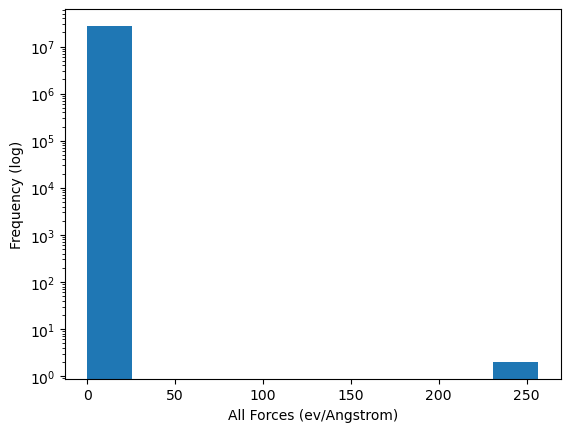

In [29]:
plt.hist(all_forces)
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.xlabel('All Forces [Start, Middle, End] (ev/Angstrom)')

Text(0.5, 0, 'All Forces (ev/Angstrom)')

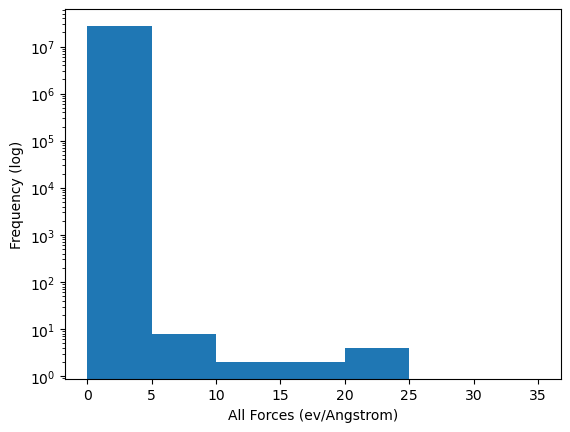

In [32]:
plt.hist(all_forces, bins=range(0, 40, 5), range=[0,40])
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.xlabel('All Forces [Start, Middle, End] (ev/Angstrom)')

In [6]:
# Histogram of all the start position forces 

In [85]:
import numpy as np

np.random.seed(19680801)

n_bins = 10
x = np.random.randn(1000, 3)

In [88]:
x

array([[ 1.04930431,  0.86609917,  0.5511346 ],
       [ 1.72807779, -0.64928812, -0.47841958],
       [ 1.07788511,  0.96881033, -0.80934479],
       ...,
       [-0.79704914, -2.08514886, -0.34828915],
       [ 0.07050817,  0.39995811, -0.91531697],
       [-1.03880531, -0.56047396, -0.95100945]])

In [ ]:
def force_mag_pair(data):
    forces_total = {}
    for mol_id in tqdm(data):
        for config in data[mol_id]:
            forces = config['gradients']
            for path_point in forces:
                for atom in path_point:
                    res = np.sqrt(sum([i**2 for i in atom]))
                    try:
                        forces_total[config['charge_spin']].append(res)
                    except KeyError:
                        forces_total[config['charge_spin']] = [res]
                    
    return forces_total

In [68]:
def beg_force_mag(data):
    forces_total = {}
    for mol_id in tqdm(data):
        for config in data[mol_id]:
            forces = config['gradients'][0]
            for atom in forces:
                res = np.sqrt(sum([i**2 for i in atom]))
                forces_total.append(res)
    return forces_total

In [8]:
def beg_force_mag_pair(data):
    forces_total = {}
    for mol_id in tqdm(data):
        for config in data[mol_id]:
            forces = config['gradients'][0]
            for atom in forces:
                res = np.sqrt(sum([i**2 for i in atom]))
                try:
                    forces_total[config['charge_spin']].append(res)
                except KeyError:
                    forces_total[config['charge_spin']] = [res]
    return forces_total

In [15]:
def beg_force_mag_pair_list(data):
    forces_total = {}
    for mol_id in tqdm(data):
        mol_id['charge_spin'] = str(mol_id['charge']) +',' + str(mol_id['spin'])
        forces = mol_id['gradients'][0]
        for atom in forces:
            res = np.sqrt(sum([i**2 for i in atom]))
            try:
                forces_total[mol_id['charge_spin']].append(res)
            except KeyError:
                forces_total[mol_id['charge_spin']] = [res]
    return forces_total

In [16]:
beg_forces_pair=beg_force_mag_pair_list(merged_data)

100%|██████████| 616958/616958 [00:15<00:00, 39978.52it/s]


In [65]:
beg_forces_pair=beg_force_mag_pair(bb)

100%|██████████| 130170/130170 [00:11<00:00, 10896.02it/s]


In [18]:
# beg_forces_pair

In [98]:
beg_forces_pair.keys()

dict_keys(['0,1', '1,2', '0,3', '-1,2'])

In [69]:
beg_forces = beg_force_mag(bb)

100%|██████████| 130170/130170 [00:12<00:00, 10569.24it/s]


Text(0.5, 0, 'All Starting Forces (ev/Angstrom)')

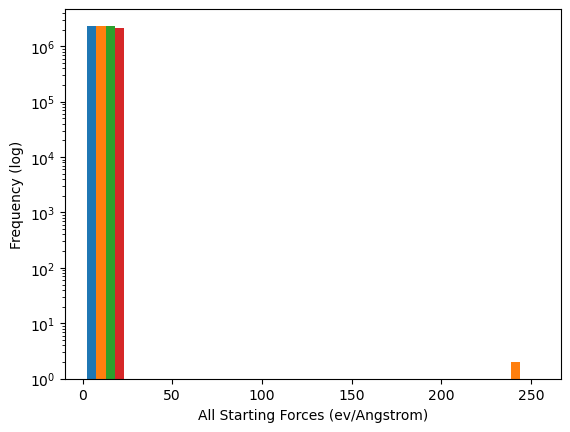

In [102]:
plt.hist([beg_forces_pair['0,1'],beg_forces_pair['1,2'], beg_forces_pair['0,3'], beg_forces_pair['-1,2']])
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.xlabel('All Starting Forces (ev/Angstrom)')

In [116]:
import pylab as pl
np.arange(0,.5,0.05)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45])

Text(0.5, 0, 'All Starting Forces (ev/Angstrom)')

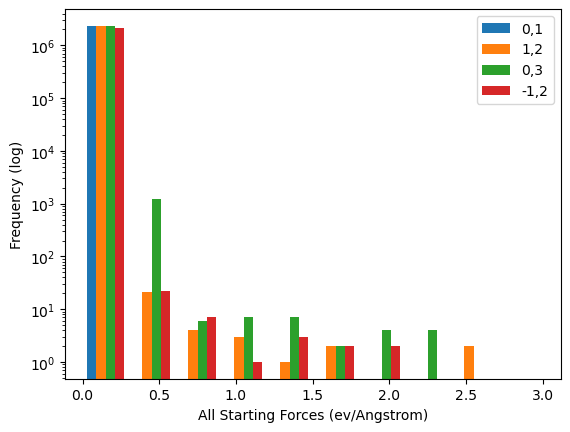

In [66]:
# plt.hist([beg_forces_pair['0,1'],beg_forces_pair['1,2'], beg_forces_pair['0,3'], beg_forces_pair['-1,2']], bins=np.arange(0,.5,0.05), range=[0,.5], label=['0,1', '1,2', '0,3', '-1,2'])
plt.hist([beg_forces_pair['0,1'],beg_forces_pair['1,2'], beg_forces_pair['0,3'], beg_forces_pair['-1,2']], range=[0,3], label=['0,1', '1,2', '0,3', '-1,2'])
plt.legend(loc='upper right')

plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.xlabel('All Starting Forces (ev/Angstrom)')

In [8]:

# Histogram of all the start position forces for -1 doublet

In [7]:
# The energy and average force (average across the atoms) of one -1 doublet throughout the trajectory

In [34]:
# Hist of all the forces for every atom at every point on the trajectory

In [13]:
def bucket_mol_id_all_pts(data: list):
    """
    Method requires a list of events such that each item in the list is a single event.
    
    Steps:
    - Bucket the events in a dictionary such that the keys are the mol_ids and the values are all events with that mol_id. Create
      a new field for each event called "charge_spin" for easy down_stream checks.
    - For each mol_id, check the list of events for duplicate "charge_spin". 
      If there are duplicates, for each duplicate pair:
                1. Get all events that have the duplicate charge_spin
                2. Remove these events from the values of the mol_id in the bucket. This is to process them and re-add them later or move to
                   bad data.
                3. Search for the order in which these duplicate events for the specific charge_spin should be attached. If there is no match,
                   this is considered bad data and will be moved out of the bucket.
                4. If an order can be established, create a new "merged" event. 
                5. Append the event to the values of the mol_id of the bucket.
                6. Repeat for every duplicate pair.
    """
    bucket = {}
    
    # Step 1    
    for event in tqdm(data):
        event['charge_spin'] = str(event['charge'])+','+str(event['spin'])
        try:
            bucket[event['mol_id']].append(event) 
        except KeyError:
            bucket[event['mol_id']] = [event]

    # Step 2
    bad_ids = []
    for mol_id in tqdm(bucket):
        pairs = [event['charge_spin'] for event in bucket[mol_id]]
        # Get a list of all charge_spins that have duplicates.
        duplicate_pairs = [item for item, count in collections.Counter(pairs).items() if count > 1] 
        non_dup_pairs = []
        if len(duplicate_pairs)!=0:
            non_dup_pairs = list(set(pairs))
            for i in duplicate_pairs:
                non_dup_pairs.remove(i)
        
        if len(duplicate_pairs)==0:
            for pair in bucket[mol_id]:
                # add weight tag
                species = pair['species']
                species_num = []
                species_sorted = ''.join(sorted(set(species)))
                for element in species:
                    species_num.append(elements_dict[element])
                    
                pair['weight_tag'] = round(sum(species_num))
        else:
            if len(non_dup_pairs)!=0:
                for pair in non_dup_pairs:
                    case_events = [event for event in bucket[mol_id] if event['charge_spin']==pair]
                    for event in case_events:
                        # add weight tag
                        species = event['species']
                        species_num = []
                        species_sorted = ''.join(sorted(set(species)))
                        for element in species:
                            species_num.append(elements_dict[element])

                        event['weight_tag'] = round(sum(species_num)) 

            bad_data = []
            for dup in duplicate_pairs:
                # Order events
                case_events = [event for event in bucket[mol_id] if event['charge_spin']==dup]
                for event in case_events:
                    bucket[mol_id].remove(event) 
                
                ordered = [case_events[0]]
                del case_events[0]
                
                counter = 0
                threshold = 30
                while len(case_events)!=0:
                    if len(bad_data)==0:
                        for event in case_events:
                            beg = event['geometries'][0]
                            end = event['geometries'][len(event['geometries'])-1]

                            ordered_beg = ordered[0]['geometries'][0]
                            ordered_end = ordered[len(ordered)-1]['geometries'][len(ordered[len(ordered)-1]['geometries'])-1]

                            if beg==ordered_end:
                                ordered.append(event)
                                case_events.remove(event)
                            elif end==ordered_beg:
                                ordered.insert(0, event)
                                case_events.remove(event)
                            else:
                                counter+=1
                                if counter>threshold:
                                    bad_data.append(mol_id)
                                else:
                                    continue
                    else:
                        break
                    
                if len(bad_data)==0:
                    pass
                else:
                    bad_ids += bad_data
                    continue

                # Merge the ordered events: forces, geometries
                merged_event = {}
                merged_event['task_id'] = ordered[0]['task_id']
                merged_event['mol_id'] = mol_id
                merged_event['name'] = ordered[0]['name']
                merged_event['charge'] = ordered[0]['charge']
                merged_event['spin'] = ordered[0]['spin']
                merged_event['charge_spin'] = ordered[0]['charge_spin']
                merged_event['species'] = ordered[0]['species']
                
                geometries = []
                energies = []
                grads = []
                mulliken = []
                resp = []
                for event in ordered:
                    geometries += event['geometries']
                    energies += event['energies']
                    grads += event['gradients']
                    mulliken += event['mulliken']
                    resp += event['resp']
               
                merged_event['geometries'] = geometries
                merged_event['energies'] = energies
                merged_event['gradients'] = grads
                merged_event['mulliken'] = mulliken
                merged_event['resp'] = resp
                
                species = merged_event['species']
                species_num = []
                species_sorted = ''.join(sorted(set(species)))
                for element in species:
                    species_num.append(elements_dict[element])
                merged_event['weight_tag'] = round(sum(species_num))
                
                bucket[mol_id].append(merged_event)

    if len(bad_ids)!=0:
        ids = list(set(bad_ids))
        for _id in ids:
            bucket.pop(_id)
        
        return ids, bucket
    else:
        for mol_id in bucket:
            if len(bucket[mol_id])>4:
                print(mol_id)
        return bucket


In [14]:
i, all_pts_bucket = bucket_mol_id_all_pts(merged_data)

100%|██████████| 133882/133882 [00:03<00:00, 40235.09it/s]


In [39]:
# with h5py.File('/pscratch/sd/m/mavaylon/sam_ldrd/ex.h5', 'r') as file:
#     gg=file['good']['good_data']
#     print(ast.literal_eval(gg[1].decode('utf-8')))
    

In [36]:
# with h5py.File('/pscratch/sd/m/mavaylon/sam_ldrd/ex.h5', 'w') as file:
#     g1 =file.create_group('good')
#     good=[]
#     for item in all_pts_bucket[3832]:
#         good.append(str(item))
#     g1.create_dataset('good_data',data=good)

In [11]:
def charge_spin_validator(bucket: dict):
    """
    The method takes in data that has been sorted into a python dictionary. They keys are the mol_ids and the values are the list of events.
    This method will check for duplicate charge_spin pairs.
    
    return: None (if valid) | bad_data-->list of invalid mol_ids (if invalid)
    """
    
    bad_data = []
    for mol_id in tqdm(bucket):
        pairs = [event['charge_spin'] for event in bucket[mol_id]]
        
        # Get a list of all charge_spins that have duplicates.
        duplicate_pairs = [item for item, count in collections.Counter(pairs).items() if count > 1]
        
        if len(duplicate_pairs)==0:
            pass
        else:
            bad_data.append(mol_id)
    
    if len(bad_data)==0:
        return None
    else:
        return bad_data

In [12]:
ff=charge_spin_validator(all_pts_bucket)
ff is None

100%|██████████| 130170/130170 [00:00<00:00, 294204.13it/s]


True

In [15]:
def average_force_trajectory(pair):
    """
    This method will take a specfic spin charge pair. At each point in the optimization trajectory, the 
    """
    forces = {}
    for i in range(len(pair['gradients'])):
        temp = []
        for atom in pair['gradients'][i]:
            res = np.sqrt(sum([j**2 for j in atom]))
            temp.append(res)
        forces[i] = np.mean(temp)
    del forces[0]
    return forces

In [16]:
def sparse_trajectory(bucket: dict):
    """
    This takes the cleaned data and will sparsifiy the optimization trajectories. How this is done will depend on the
    charge_spin pair:
    - Neutral Singlet (0,1): First and Last
    - Other: First, Last, and structure with the highest molecular force other than the First.
    
    Note: Molecular Force is just the average of the force magnitudes of each atom in the molecule:
    """
    
    for mol_id in tqdm(bucket):
        for pair in bucket[mol_id]:
            if pair['charge_spin'] == '0,1':
                geometries = [pair['geometries'][0], pair['geometries'][-1]]
                energies = [pair['energies'][0], pair['energies'][-1]]
                grads = [pair['gradients'][0], pair['gradients'][-1]]
                mulliken = [pair['mulliken'][0], pair['mulliken'][-1]]
                resp = [pair['resp'][0], pair['resp'][-1]]
                
                pair['geometries'] = geometries
                pair['energies'] = energies
                pair['gradients'] = grads
                pair['mulliken'] = mulliken
                pair['resp'] = resp
            else:
                force_dict = average_force_trajectory(pair)
                max_index = max(force_dict, key=force_dict.get)
                
                geometries = [pair['geometries'][0], pair['geometries'][max_index], pair['geometries'][-1]]
                energies = [pair['energies'][0], pair['energies'][max_index], pair['energies'][-1]]
                grads = [pair['gradients'][0], pair['gradients'][max_index], pair['gradients'][-1]]
                mulliken = [pair['mulliken'][0], pair['mulliken'][max_index], pair['mulliken'][-1]]
                resp = [pair['resp'][0], pair['resp'][max_index], pair['resp'][-1]]
                
                pair['geometries'] = geometries
                pair['energies'] = energies
                pair['gradients'] = grads
                pair['mulliken'] = mulliken
                pair['resp'] = resp

In [17]:
sparsed_bucket = sparse_trajectory(all_pts_bucket)

100%|██████████| 130170/130170 [06:32<00:00, 331.86it/s]


In [48]:
# all_pts_bucket[3832]

In [18]:
force_filtered, filtered_data = force_magnitude_filter(cutoff=10.0, data=all_pts_bucket)

100%|██████████| 130170/130170 [00:32<00:00, 3976.63it/s]


In [28]:
filtered_data

KeyError: 0

In [15]:
def prepare_graph_filter(data: dict):
    """
    Go through the data and retrieve the data needed for graph separation check.
    1. Ignore charge_spin pair = 0,1
    2. Ignore all starting points in the configurations.
    """
    data_to_be_parsed = []
    for mol_id in tqdm(data):
        for pair in data[mol_id]:
            if pair['charge_spin'] != '0,1':
                data_to_be_parsed.append(pair)
    
    # Ignore the first is in the filter_broken_graphs
    return data_to_be_parsed

In [55]:
def removed_broken_graph_data(data: dict,
                              broken: list):
    """
    
    """
    data_to_be_parsed = {}
    for mol_id in tqdm(data):
        for pair in data[mol_id]:
            # data_to_be_parsed.append(pair)
            data_to_be_parsed[str(pair['task_id']) +'_'+str(pair['mol_id'])+'_'+pair['charge_spin']] = pair
    print(len(data_to_be_parsed))
    
    print(len(broken))
    for item in tqdm(broken):
        data_to_be_parsed.pop(item)
    
    print(len(data_to_be_parsed))
    
    return data_to_be_parsed

In [16]:
dd = prepare_graph_filter(filtered_data)

100%|██████████| 130170/130170 [00:00<00:00, 431678.02it/s]


In [29]:
def flatten(data):
    return [x for y in data for x in y]

In [56]:
flattend_data = removed_broken_graph_data(filtered_data, broken_dict)

100%|██████████| 130170/130170 [00:00<00:00, 177590.97it/s]


509920
17353


100%|██████████| 17353/17353 [00:00<00:00, 1399849.16it/s]

492567


130170

In [71]:
len(set(broken_data))

TypeError: unhashable type: 'dict'

In [22]:
# [x for x in flattend_data if x==broken_data[0]]
# for item in tqdm(broken_data):
#     print(item)
#     break
# flattend_data.remove(broken_data[44])
# flattend_data

In [ ]:

#     atoms = read("foo.xyz")
#     mol = AseAtomsAdaptor.get_molecule(atoms)
#     graph = MoleculeGraph.with_local_env_strategy(mol, OpenBabelNN())

#     nx.is_connected(graph.graph.to_undirected()) 

In [17]:
def filter_broken_graphs(data: list):
    broken = []
    good = []
    
    for item in tqdm(data):
        for traj_point in item['geometries'][1:]:
                atoms = ase.atoms.Atoms(symbols=item['species'],
                                        positions=traj_point)
                mol = AseAtomsAdaptor.get_molecule(atoms)
                graph = MoleculeGraph.with_local_env_strategy(mol, OpenBabelNN())

                connected = nx.is_connected(graph.graph.to_undirected())
                if not connected:
                    broken.append(item)
                else:
                    good.append(item)

    return good, broken

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
import h5py
file = h5py.File('/pscratch/sd/m/mavaylon/sam_ldrd/broken.h5', 'r')


In [31]:
import ast
import h5py
file = h5py.File('/pscratch/sd/m/mavaylon/sam_ldrd/broken.h5', 'r')

broken_dict={}
for point in tqdm(file['broken']['broken_data']):
    try:
        point = ast.literal_eval(point.decode('utf-8'))
        broken_dict[str(point['task_id']) +'_'+str(point['mol_id'])+'_'+point['charge_spin']] = point
    except KeyError:
        pass


100%|██████████| 25888/25888 [00:34<00:00, 749.68it/s]


In [29]:
broken_data[0]['task_id']
str(broken_data[0]['task_id']) +'_'+str(broken_data[0]['mol_id'])+'_'+broken_data[0]['charge_spin']

'409851_3838_-1,2'

In [26]:
import h5py
with h5py.File('/pscratch/sd/m/mavaylon/sam_ldrd/good.h5', 'w') as file:
    g1 =file.create_group('good')
    good_d=[]
    for item in good:
        good.append(str(item))
    g1.create_dataset('good_data',data=good_)

In [31]:
# import h5py
# with h5py.File('/pscratch/sd/m/mavaylon/sam_ldrd/broken.h5', 'w') as file:
#     g1 =file.create_group('broken')
#     bbd=[]
#     for item in broken:
#         bbd.append(str(item))
#     g1.create_dataset('broken_data',data=bbd)

In [57]:
# good,broken = filter_broken_graphs(dd)

In [30]:
atoms = read("/pscratch/sd/m/mavaylon/sam_ldrd/C4H8_disconnected.xyz")
mol = AseAtomsAdaptor.get_molecule(atoms)
graph = MoleculeGraph.with_local_env_strategy(mol, OpenBabelNN())

In [19]:
# mol

In [35]:
# all_pts_bucket[3832][0]['geometries'][0]
atoms = ase.atoms.Atoms(symbols=all_pts_bucket[3832][0]['species'],
                        positions=all_pts_bucket[3832][0]['geometries'][0]
)
mol2 = AseAtomsAdaptor.get_molecule(atoms)
graph = MoleculeGraph.with_local_env_strategy(mol2, CovalentBondNN())
mol2

Molecule Summary
Site: N (-0.0904, 1.3272, 0.0010)
Site: C (0.0056, 0.0445, 0.0073)
Site: C (1.2227, -0.7649, 0.0032)
Site: N (1.2304, -2.0620, 0.0100)
Site: N (0.0409, -2.6663, 0.0216)
Site: N (-1.1681, -2.0892, 0.0272)
Site: C (-1.1903, -0.7936, 0.0205)
Site: H (0.8384, 1.7557, -0.0079)
Site: H (2.1979, -0.2844, -0.0065)
Site: H (0.0527, -3.6722, 0.0267)
Site: H (-2.1670, -0.3209, 0.0249)

In [26]:
graph
nx.is_connected(graph.graph.to_undirected())

True

In [20]:
# all_pts_bucket.keys()
# 3832, 4139, 908, 2715
# [x for x in all_pts_bucket[3832] if x['spin']==3]


In [16]:
sample_3832 = [x for x in all_pts_bucket[3832] if x['charge_spin']=='0,3'][0]
sample_4083 = [x for x in all_pts_bucket[4083] if x['charge_spin']=='0,3'][0]
sample_908 = [x for x in all_pts_bucket[908] if x['charge_spin']=='0,3'][0]
sample_2715 = [x for x in all_pts_bucket[2715] if x['charge_spin']=='0,3'][0]
sample_52232 = [x for x in all_pts_bucket[52232] if x['charge_spin']=='0,3'][0]

In [61]:
len(sample['gradients'])

37

In [18]:
traj_3832=average_force_trajectory(sample_3832)
traj_4083=average_force_trajectory(sample_4083)
traj_908=average_force_trajectory(sample_908)
traj_2715=average_force_trajectory(sample_2715)
traj_52232=average_force_trajectory(sample_52232)

Text(0.5, 0.98, "Force and Energy vs Optimization Step (Mol_id:3832, Charge_Spin: '0,3')")

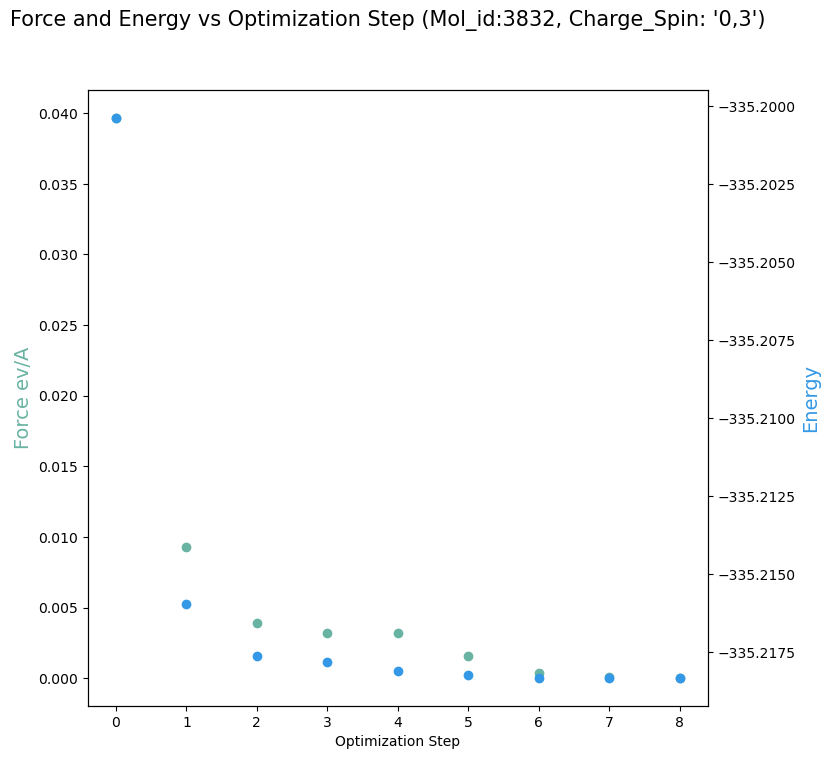

In [24]:
force_color = "#69b3a2"
energy_color = "#3399e6"

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.set_xlabel("Optimization Step")


ax2 = ax1.twinx()
ax1.plot(range(len(traj_3832)), traj_3832, 'o', color=force_color)
ax1.set_ylabel("Force ev/A", color=force_color, fontsize=14)

ax2.plot(range(len(traj_3832)), sample_3832['energies'], 'o', color=energy_color)
ax2.set_ylabel("Energy", color=energy_color, fontsize=14)
fig.suptitle("Force and Energy vs Optimization Step (Mol_id:3832, Charge_Spin: '0,3')", fontsize=15)


Text(0.5, 0.98, "Force and Energy vs Optimization Step (Mol_id:908, Charge_Spin: '0,3')")

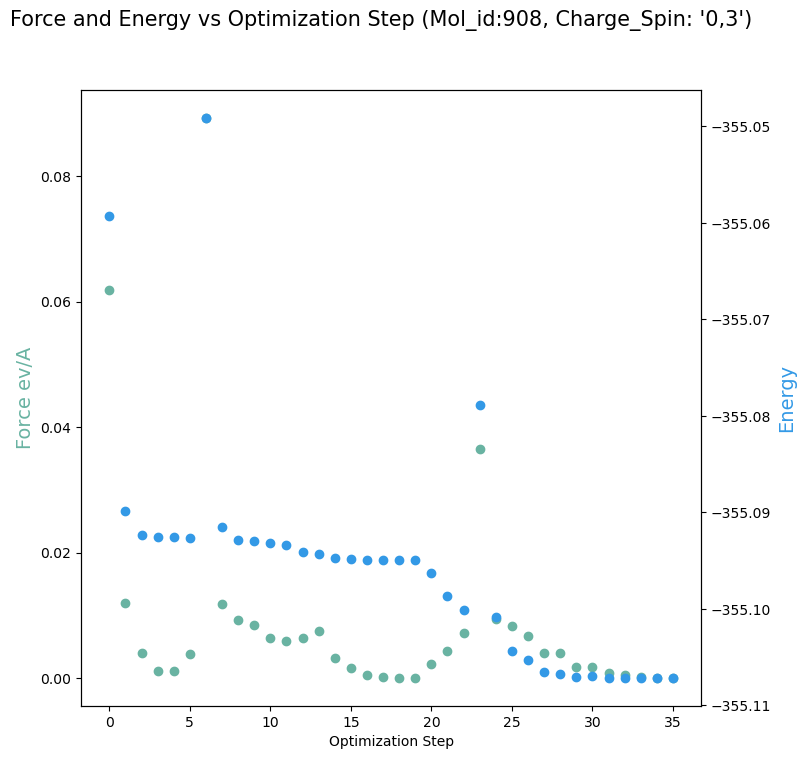

In [25]:
force_color = "#69b3a2"
energy_color = "#3399e6"

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.set_xlabel("Optimization Step")


ax2 = ax1.twinx()
ax1.plot(range(len(traj_908)), traj_908, 'o', color=force_color)
ax1.set_ylabel("Force ev/A", color=force_color, fontsize=14)

ax2.plot(range(len(traj_908)), sample_908['energies'], 'o', color=energy_color)
ax2.set_ylabel("Energy", color=energy_color, fontsize=14)
fig.suptitle("Force and Energy vs Optimization Step (Mol_id:908, Charge_Spin: '0,3')", fontsize=15)


Text(0.5, 0.98, "Force and Energy vs Optimization Step (Mol_id:4083, Charge_Spin: '0,3')")

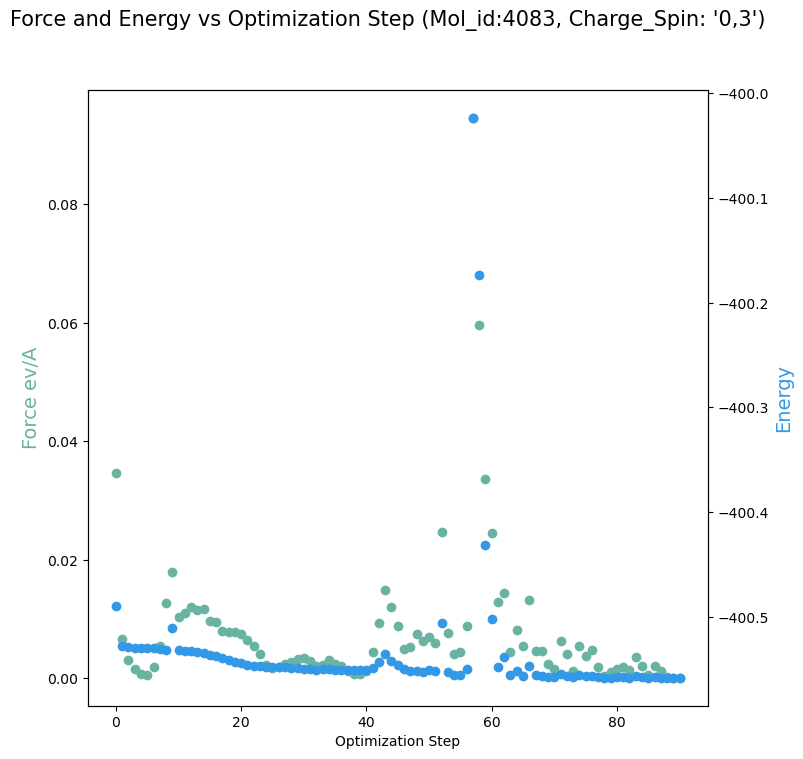

In [26]:
force_color = "#69b3a2"
energy_color = "#3399e6"

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.set_xlabel("Optimization Step")


ax2 = ax1.twinx()
ax1.plot(range(len(traj_4083)), traj_4083, 'o', color=force_color)
ax1.set_ylabel("Force ev/A", color=force_color, fontsize=14)

ax2.plot(range(len(traj_4083)), sample_4083['energies'], 'o', color=energy_color)
ax2.set_ylabel("Energy", color=energy_color, fontsize=14)
fig.suptitle("Force and Energy vs Optimization Step (Mol_id:4083, Charge_Spin: '0,3')", fontsize=15)


Text(0.5, 0.98, "Force and Energy vs Optimization Step (Mol_id:2715, Charge_Spin: '0,3')")

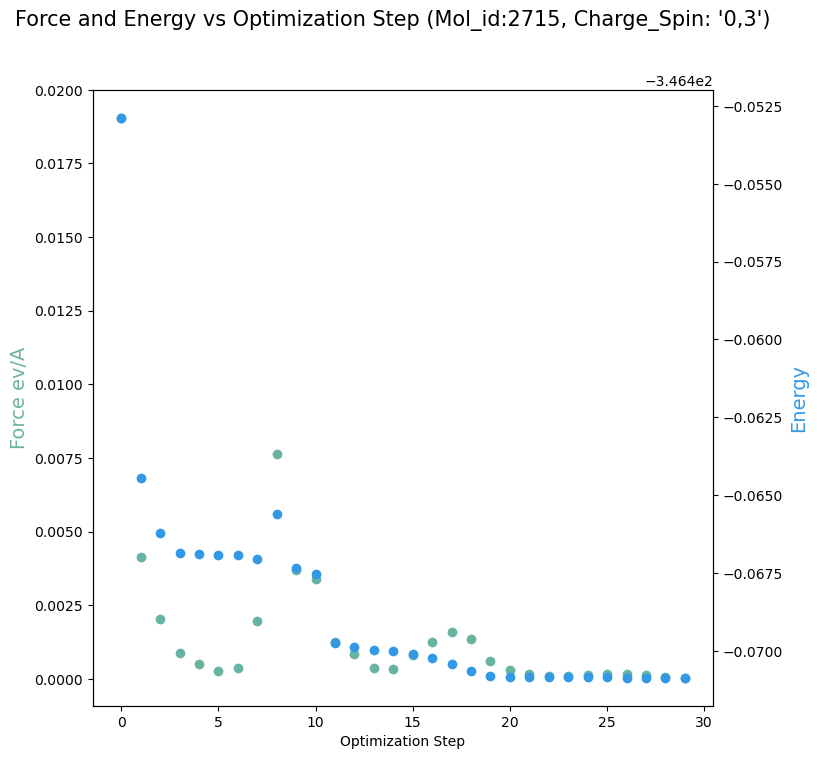

In [27]:
force_color = "#69b3a2"
energy_color = "#3399e6"

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.set_xlabel("Optimization Step")


ax2 = ax1.twinx()
ax1.plot(range(len(traj_2715)), traj_2715, 'o', color=force_color)
ax1.set_ylabel("Force ev/A", color=force_color, fontsize=14)

ax2.plot(range(len(traj_2715)), sample_2715['energies'], 'o', color=energy_color)
ax2.set_ylabel("Energy", color=energy_color, fontsize=14)
fig.suptitle("Force and Energy vs Optimization Step (Mol_id:2715, Charge_Spin: '0,3')", fontsize=15)


Text(0.5, 0.98, "Force and Energy vs Optimization Step (Mol_id:52232, Charge_Spin: '0,3')")

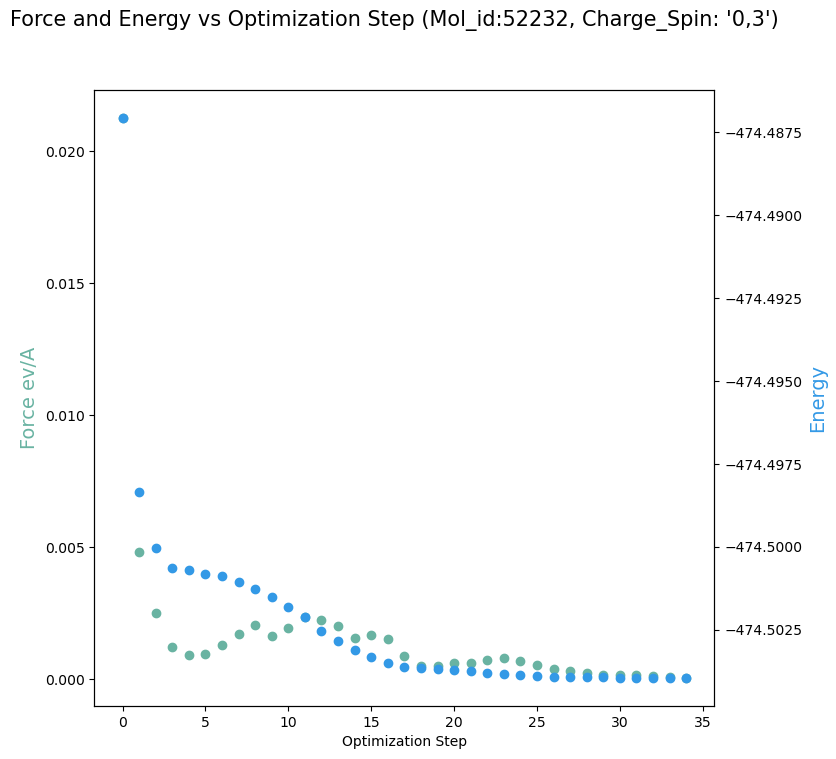

In [28]:
force_color = "#69b3a2"
energy_color = "#3399e6"

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.set_xlabel("Optimization Step")


ax2 = ax1.twinx()
ax1.plot(range(len(traj_52232)), traj_52232, 'o', color=force_color)
ax1.set_ylabel("Force ev/A", color=force_color, fontsize=14)

ax2.plot(range(len(traj_52232)), sample_52232['energies'], 'o', color=energy_color)
ax2.set_ylabel("Energy", color=energy_color, fontsize=14)
fig.suptitle("Force and Energy vs Optimization Step (Mol_id:52232, Charge_Spin: '0,3')", fontsize=15)


In [36]:
# bb[3892]